In [116]:
%load_ext autoreload
%autoreload 2
from utils import *
from tqdm.notebook import tqdm
import pandas as pd
import os
import scienceplots
seed = 1 

plt.rcParams.update(plt.rcParamsDefault)

tf.random.set_seed(seed)
np.random.seed(seed)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [117]:
model = tf.keras.models.load_model('../models/siren_broaden_instrument')

In [118]:
# Experimental data 
path = '../data_experimental/'

c_q_slice1 = np.array(pd.read_csv(os.path.join(path, 'Qlist_path2_woBG.csv'), header=None)).T
c_E_slice1 = np.array(pd.read_csv(os.path.join(path, 'Elist_path2_woBG.csv'), header=None)[0]).T
c_sqw_slice1 = np.array(pd.read_csv(os.path.join(path, 'Sqw_path2.csv'), header=None)).T
    
c_q_slice2 = np.array(pd.read_csv(os.path.join(path, 'Qlist_path3_woBG.csv'), header=None)).T
c_E_slice2 = np.array(pd.read_csv(os.path.join(path, 'Elist_path3_woBG.csv'), header=None)[0]).T
c_sqw_slice2 = np.array(pd.read_csv(os.path.join(path, 'Sqw_path3.csv'), header=None)).T

In [119]:
num_neutrons = [] 
mc_simulations = [] 
preds = [] 

# parameters for gradient descent 
batch_size = 1024 # number of pixels across both slices; stochastic optimization to find better minima
max_iter = 2000
learning_rate = 0.01
n_restarts = 10
n_samples_list = [5000, 10000, 25000, 50000, 75000, 100000, 150000, 200000, 300000, 500000, 750000, 1000000,2000000, 3000000,5000000]

# note n_samples != n_neutrons since the rejection sampling procedure is not very efficient 
for n_samples in tqdm(n_samples_list):
    
    # Sample from experimentally smoothed "probability" distribution 
    c_sqw_rs_slice1 = rejection_sampling(c_sqw_slice1, n_samples=n_samples).T
    c_sqw_rs_slice2 = rejection_sampling(c_sqw_slice2, n_samples=n_samples).T
    mc_simulations.append([c_sqw_rs_slice1, c_sqw_rs_slice2]) # save mc simulation 
        
    # convert data to (q,E) from pixel space 
    test_x_1, test_y_1 = image_to_coords(c_q_slice1, c_E_slice1, c_sqw_rs_slice1, background_start=150,background_end=160)
    test_x_2, test_y_2 = image_to_coords(c_q_slice2, c_E_slice2, c_sqw_rs_slice2, background_start=95,background_end=100)
    
    # convert to tensors 
    test_x = tf.convert_to_tensor(np.vstack((test_x_1, test_x_2[test_y_2 != 0])), dtype=tf.float32)
    test_y = tf.convert_to_tensor(np.concatenate((test_y_1, test_y_2[test_y_2 != 0])), dtype=tf.float32)
    
    # count total number of neutrons (i.e. just sum image)
    n_1 = np.sum(c_sqw_rs_slice1)
    n_2 = np.sum(c_sqw_rs_slice2)
    num_neutrons.append([n_1 + n_2])
        
    pred_iter = [] # stores the result of n_restart gradient descent optimizations 
    
    for n in range(n_restarts):
        min_loss, min_loss_j1, min_loss_j2, _  = optimize_surrogate(test_x, 
                                                                    test_y, 
                                                                    model,
                                                                    learning_rate = learning_rate,
                                                                    batch_size = batch_size, 
                                                                    max_iter=max_iter, plotting = False)
        
        pred_iter.append([min_loss_j1, min_loss_j2, min_loss])
        
    preds.append(pred_iter)
    
    print("number of neutrons: ", n_1 + n_2, "Best prediction (lowest loss): ", pred_iter[np.argmin(np.array(pred_iter)[:,2])], "Std prediction: ", np.std(pred_iter,axis=0))
    
preds = np.array(preds)
num_neutrons = np.array(num_neutrons)
mc_simulations = np.array(mc_simulations)


  0%|          | 0/15 [00:00<?, ?it/s]

number of neutrons:  894.0 Best prediction (lowest loss):  [0.05382020026445389, 1.4214023351669312, 0.5750263929367065] Std prediction:  [0.1659497 0.4440306 0.0338284]
number of neutrons:  1829.0 Best prediction (lowest loss):  [0.14767837524414062, 1.484950065612793, 0.6367151737213135] Std prediction:  [0.13905255 0.47220419 0.02718607]
number of neutrons:  4467.0 Best prediction (lowest loss):  [0.4511072635650635, 0.7365950345993042, 0.6792015433311462] Std prediction:  [0.12003966 0.46173781 0.01489968]
number of neutrons:  8933.0 Best prediction (lowest loss):  [0.4547896087169647, 0.1279734969139099, 0.6105911731719971] Std prediction:  [0.12610555 0.63349831 0.02116196]
number of neutrons:  13458.0 Best prediction (lowest loss):  [0.47027045488357544, 0.008631734177470207, 0.6475332379341125] Std prediction:  [0.12565692 0.63424272 0.01326812]
number of neutrons:  17669.0 Best prediction (lowest loss):  [0.4547877609729767, 0.1601288616657257, 0.6136443614959717] Std predicti

KeyboardInterrupt: 

In [ ]:
np.save('predictions_low_count_4', preds)
np.save('neutrons_low_count_4', num_neutrons)
np.save('mc_simulations_4', mc_simulations)

In [121]:
preds = np.load('predictions_low_count_3.npy')
num_neutrons = np.load('neutrons_low_count_3.npy')
mc_simulations = np.load('mc_simulations_3.npy',allow_pickle = True)

In [150]:
[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# Visualize data and predictions

array([[0.13474707, 1.49623287, 0.8292307 ],
       [0.16287585, 0.79438581, 0.84226203],
       [0.15173188, 1.49255884, 0.79549494],
       [0.24102566, 1.47211009, 0.75833413],
       [0.34296589, 0.81955866, 0.73230565],
       [0.22817691, 1.20579302, 0.73011586],
       [0.41497369, 0.47215972, 0.68764845],
       [0.32572246, 1.18610609, 0.65382582],
       [0.32697073, 1.1860348 , 0.60916978],
       [0.32334001, 1.1970945 , 0.55606616],
       [0.32397188, 1.20808333, 0.52194157],
       [0.324497  , 1.2081883 , 0.49477163],
       [0.32342727, 1.21683937, 0.4581995 ],
       [0.32253794, 1.21451443, 0.43230751],
       [0.32417822, 1.21924323, 0.42518038]])

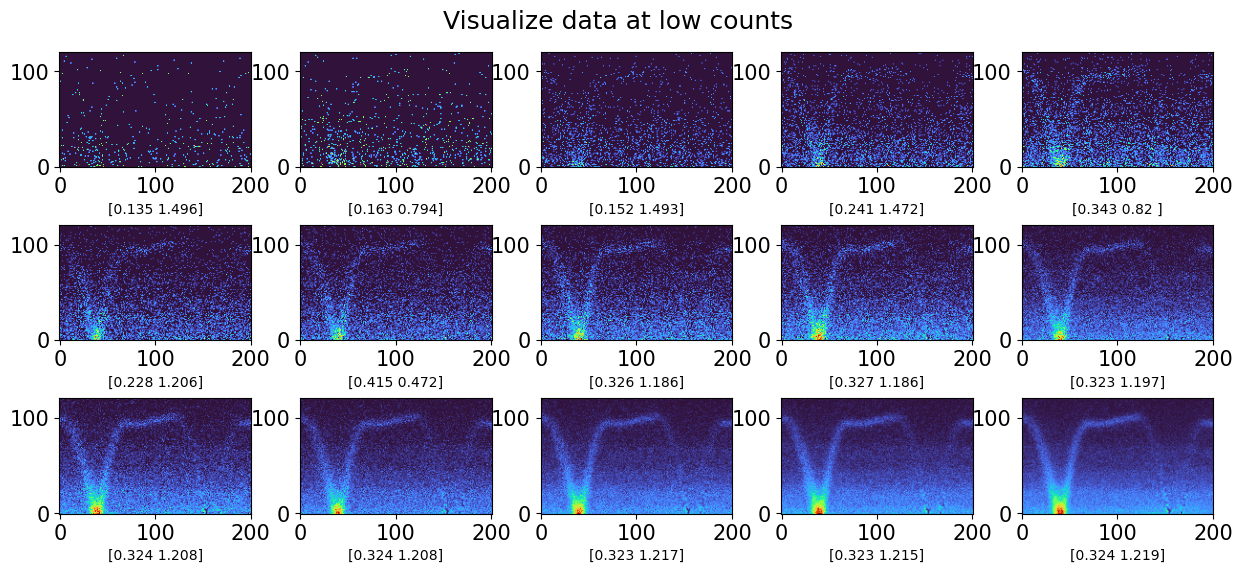

------------------------------------------------------------------------------------------------


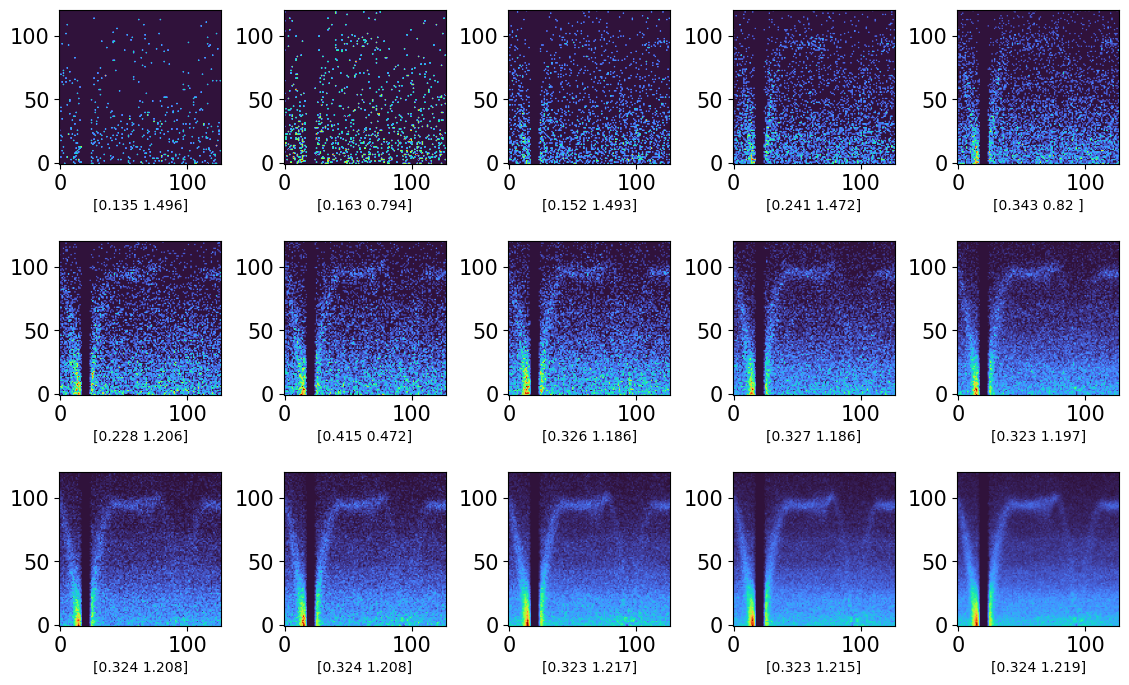

In [195]:
fig, axs = plt.subplots(nrows=3, ncols=5, figsize=(15, 6))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Visualize data at low counts", fontsize=18, y=0.95)

# loop through tickers and axes
for i, ax in enumerate(axs.ravel()):
    
    slice_1 = mc_simulations[i][0]
    slice_1 = slice_1/np.sum(slice_1)
    
    ax.imshow(slice_1.T, origin = 'lower', cmap = 'turbo')
    ax.set_xlabel(np.round(np.median(preds,axis=1)[i,0:2],3), fontsize = 10)
plt.show()

print('------------------------------------------------------------------------------------------------')

fig, axs = plt.subplots(nrows=3, ncols=5, figsize=(14, 8))
plt.subplots_adjust(hspace=0.5)
# loop through tickers and axes
for i, ax in enumerate(axs.ravel()):
    
    slice_2 = mc_simulations[i][1]
    slice_2 = slice_2/np.sum(slice_2)
    
    ax.imshow(slice_2.T, origin = 'lower', cmap = 'turbo')
    ax.set_xlabel(np.round(np.median(preds,axis=1)[i,0:2],3), fontsize = 10)
plt.show()

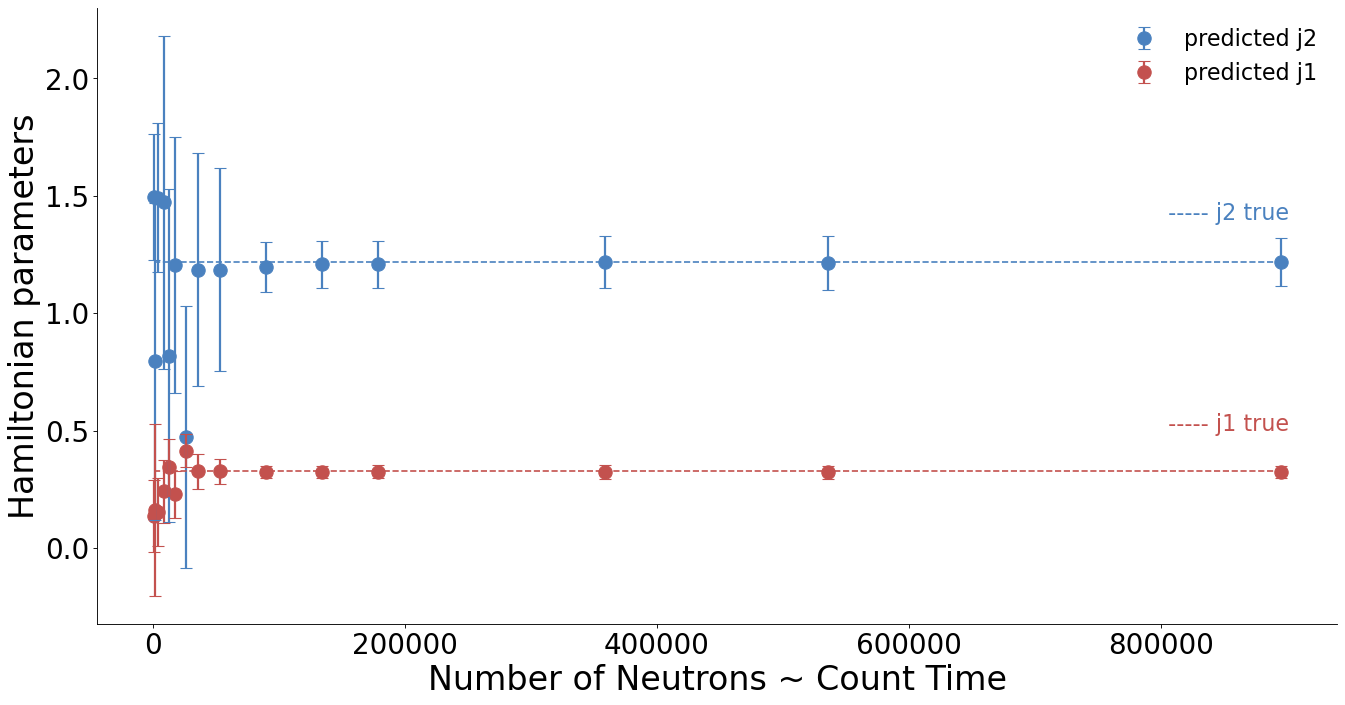

In [184]:
from matplotlib.pyplot import figure
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 20

figure(figsize=(20, 10), dpi=80)

plt.errorbar(num_neutrons, np.median(preds[:,:,1],axis=1), np.std(preds[:,:,1],axis=1), fmt = 'o', ms = 12, elinewidth=2, capsize=5, barsabove=True, label = 'predicted j2', color = '#4A81BF')
plt.errorbar(num_neutrons, np.median(preds[:,:,0],axis=1), np.std(preds[:,:,0],axis=1), fmt = 'o', ms = 12, elinewidth=2, capsize=5, barsabove=True, label = 'predicted j1', color = '#C3514E')
plt.plot(num_neutrons, 0.328*np.ones(num_neutrons.shape), "--", color = '#C3514E')
plt.plot(num_neutrons, 1.2198*np.ones(num_neutrons.shape), "--", color = '#4A81BF')
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlabel('Number of Neutrons ~ Count Time', fontsize = 30)
plt.ylabel('Hamiltonian parameters', fontsize = 30)
plt.legend(fontsize=20, frameon=False)
plt.annotate(' ----- j1 true', (800000,0.5), fontsize = 20, color='#C3514E')
plt.annotate(' ----- j2 true', (800000,1.4), fontsize = 20, color='#4A81BF')
#plt.axvspan(83000, 950000, color = 'gold', alpha = 0.1, zorder = 0)  #vertical shading
#plt.axvline(83000, color = 'gold', alpha = 0.1)  #vertical line
plt.savefig('destination_path.eps', format='eps')
plt.show()